# Covid-19 Vaccines in California and their Impacts

### Hypothesis:
#### 1.	College towns had an impact on Covid-19 surges in 2020.
#### 2.	Vaccines have directly impacted California’s case and death rates.

In [1]:
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import requests
from census import Census
from us import states
import gmaps
import json

#import API key for US Census API
from config import api_key
c = Census(api_key)

#import API key for gmaps
from config import gkey
gmaps.configure(api_key=gkey)

### Cleaning Data

In [2]:
# Cleaning Cases Data
case_df = pd.read_csv("Data/covid19cases_test.csv")
case_df.head()

,date,area,area_type,population,cases,deaths,total_tests,positive_tests,reported_cases,reported_deaths,reported_tests
0,4/23/2021,Alameda,County,1685886.0,0.0,0.0,NaN,NaN,106.0,3.0,11251.0
1,4/23/2021,Alpine,County,1117.0,0.0,0.0,NaN,NaN,0.0,0.0,2.0
2,4/23/2021,Amador,County,38531.0,0.0,0.0,NaN,NaN,4.0,0.0,487.0
3,4/23/2021,Butte,County,217769.0,0.0,0.0,NaN,NaN,16.0,0.0,454.0
4,4/23/2021,Calaveras,County,44289.0,0.0,0.0,NaN,NaN,5.0,0.0,135.0


In [3]:
# change date column to easier to compare format
case_df.date = pd.to_datetime(case_df['date'],format='%m/%d/%Y')

# filter out dates past 3-31-21, as well as rows with useless data
clean_case = case_df.loc[(case_df.date<dt.datetime(2021,4,1)) & \
                         (case_df.area != 'Out of state') & \
                         (case_df.area != 'California')& \
                         (case_df.area != 'Unknown')]

# filter out columns we dont need
clean_case = clean_case[['date','area','population','cases','deaths','total_tests','positive_tests']]

# replace missing data with 0
clean_case = clean_case.fillna(0)
clean_case

,date,area,population,cases,deaths,total_tests,positive_tests
1403,2021-03-31,Alameda,1685886.0,98.0,1.0,10553.0,123.0
1404,2021-03-31,Alpine,1117.0,0.0,0.0,3.0,0.0
1405,2021-03-31,Amador,38531.0,3.0,0.0,317.0,8.0
1406,2021-03-31,Butte,217769.0,11.0,0.0,632.0,11.0
1407,2021-03-31,Calaveras,44289.0,4.0,0.0,80.0,4.0
...,...,...,...,...,...,...,...
27322,2020-02-01,Tulare,484423.0,0.0,0.0,0.0,0.0
27323,2020-02-01,Tuolumne,52351.0,0.0,0.0,0.0,0.0
27325,2020-02-01,Ventura,852747.0,0.0,0.0,1.0,0.0
27326,2020-02-01,Yolo,223612.0,0.0,0.0,0.0,0.0


In [4]:
# Cleaning Vaccinations Data
vaccine_csv_path = "Data/covid19vaccinesbycounty.csv"
vaccine_df = pd.read_csv(vaccine_csv_path)
vaccine_df.head()

vaccine_csv_path = "Data/covid19vaccinesbycounty.csv"
vaccine_df = pd.read_csv(vaccine_csv_path)

vaccine_df=vaccine_df.drop(columns=['cumulative_pfizer_doses',
                         'cumulative_moderna_doses','cumulative_jj_doses',
                         'cumulative_at_least_one_dose', 'california_flag'])
vaccine_df=vaccine_df.drop(vaccine_df[(vaccine_df['county']=='All CA Counties')|(vaccine_df['county']=='All CA and Non-CA Counties')|(vaccine_df['county']=='Outside California')|(vaccine_df['county']=='Unknown')].index)
vaccine_df

,county,administered_date,total_doses,cumulative_total_doses,pfizer_doses,moderna_doses,jj_doses,partially_vaccinated,total_partially_vaccinated,fully_vaccinated,cumulative_fully_vaccinated,at_least_one_dose
511,Alameda,12/15/2020,36,36,36,0,0,36,36,0,0,36
512,Alameda,12/16/2020,202,238,202,0,0,202,238,0,0,202
513,Alameda,12/17/2020,396,634,396,0,0,396,634,0,0,396
514,Alameda,12/18/2020,1766,2400,1765,1,0,1766,2400,0,0,1766
515,Alameda,12/19/2020,1357,3757,1357,0,0,1357,3757,0,0,1357
...,...,...,...,...,...,...,...,...,...,...,...,...
7761,Yuba,4/19/2021,244,29485,102,142,0,103,5934,141,12839,103
7762,Yuba,4/20/2021,302,29787,79,223,0,177,5987,125,12964,178
7763,Yuba,4/21/2021,694,30481,283,411,0,299,5891,395,13359,299
7764,Yuba,4/22/2021,269,30750,95,174,0,149,5920,120,13479,149


In [5]:
#Cumulative CA Vaccination dataframe:
ca_vaccinations=vaccine_df.groupby(['administered_date'],as_index=False).agg({'cumulative_total_doses':['sum']})
ca_vaccinations.columns = ca_vaccinations.columns.droplevel(1)
ca_vaccinations.administered_date = pd.to_datetime(ca_vaccinations['administered_date'],format='%m/%d/%Y')
ca_vaccinations['cumulative_doses_by_10000']=ca_vaccinations.apply(lambda row: row.cumulative_total_doses/10000,axis=1)
ca_vaccinations

,administered_date,cumulative_total_doses,cumulative_doses_by_10000
0,2021-01-01,509458,50.9458
1,2021-01-10,973267,97.3267
2,2021-01-11,1080894,108.0894
3,2021-01-12,1193160,119.3160
4,2021-01-13,1311540,131.1540
...,...,...,...
125,2021-04-05,20646749,2064.6749
126,2021-04-06,21095665,2109.5665
127,2021-04-07,21558639,2155.8639
128,2021-04-08,22046520,2204.6520


In [ ]:
# Cleaning Hospital Data

In [6]:
# Cleaning Colleges Data
college_data = pd.read_csv('Data/ca_colleges.csv')

college_data.columns = ['School_ID', 'School_name', 'Year', 'Duplicate', 'Street_Address', 'City', 'Zip_code', 
                        'county', 'Longitude', 'Latitude', 'Total_Enrollment', 'Full_time_enrollment', 
                        'Part_time_enrollment']

college_data.drop(columns=['School_ID', 'Year', 'Duplicate', 'Street_Address', 'City', 'Zip_code', 
                        'Full_time_enrollment', 'Part_time_enrollment'], inplace=True)

college_data.county = college_data.county.map(lambda x: x[ :-7])
college_data.dropna(subset=['Total_Enrollment'], inplace=True)
college_data.to_csv('Data/college_data.csv', index=False)

college_data.head()

,School_name,county,Longitude,Latitude,Total_Enrollment
0,Academy of Art University,San Francisco,-122.400578,37.787943,9812.0
1,Academy of Chinese Culture and Health Sciences,Alameda,-122.269839,37.805972,133.0
3,Avalon School of Cosmetology-Alameda,Alameda,-122.243566,37.764203,47.0
4,College of Alameda,Alameda,-122.279303,37.781017,5667.0
5,Allan Hancock College,Santa Barbara,-120.421144,34.943716,11894.0


### Connecting API

In [7]:
states.CA.fips

'06'

In [8]:
census_data = c.acs5.get(('NAME', 'B19013_001E', 'B19301_001E', 'B17001_002E', 
                         'B01003_001E'), geo={'for': 'zip code tabulation area:*', 'in': 'state:06'})
census_data[0]

#Converting to DataFrame
census_df = pd.DataFrame(census_data)

census_df.rename(columns={'B19013_001E': 'Household_Income',
                         'B19301_001E': 'Income_per_Capita',
                         'B17001_002E': 'Poverty_Count', 
                         'B01003_001E': 'Population', 
                         'NAME': 'Name', 
                          'zip code tabulation area': 'Zipcode'}, inplace=True)
census_df = census_df.loc[census_df.Household_Income>0].copy()
census_df.drop(columns=['Name', 'Poverty_Count', 'state'], inplace=True)
census_df = census_df[['Zipcode', 'Household_Income', 'Income_per_Capita', 'Population']]
census_df.head()

,Zipcode,Household_Income,Income_per_Capita,Population
0,95126,92788.0,54954.0,35988.0
1,95134,139558.0,65665.0,27224.0
2,95202,14484.0,12408.0,6001.0
3,95209,78883.0,27963.0,44313.0
4,95222,52289.0,36554.0,5090.0


In [9]:
# Exporting data as csv
census_df.to_csv('Data/Census_data.csv', encoding='utf-8', index=False)

### Summary Statistics

## Research Analysis

### 1.	How has the introduction of the Covid vaccine affected case/death rate in California?

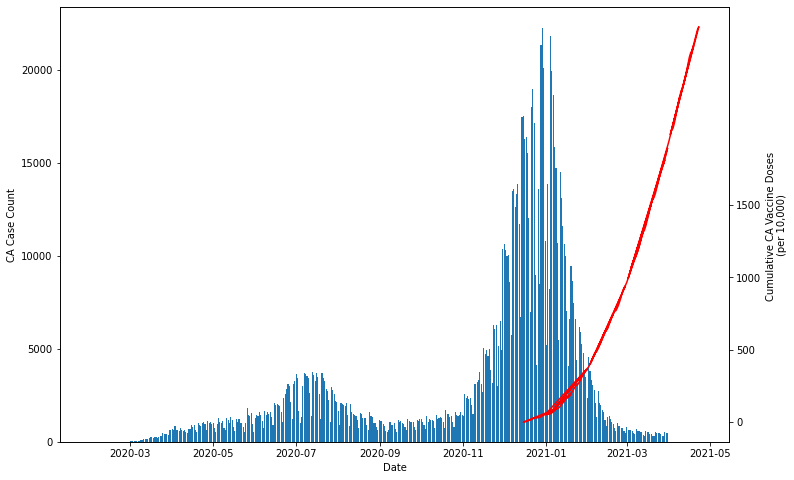

In [12]:
#Covid cases vs. vaccinations

#covid case & dates for bar graph
x1=(clean_case['date'])
y1=(clean_case['cases'])

#vaccine counts and dates for line graph
x2=ca_vaccinations['administered_date']
y2=ca_vaccinations['cumulative_doses_by_10000']

#format figure
fig, axis1 = plt.subplots(figsize=(12,8))
axis2=axis1.twinx()    #create a second axis sharing the x-axis

#create bar graph using CA case counts
axis1.bar(x1,y1,)
axis1.set_ylabel("CA Case Count")
axis1.set_xlabel('Date')

#plot cumulative vaccine counts on 2nd y-axis
axis2.plot(x2,y2,color='red')
axis2.set_ylabel('Cumulative CA Vaccine Doses \n(per 10,000)')

#change y-ticks for 2nd axis
axis2.set_yticks(np.arange(0,2000,500))

plt.show()

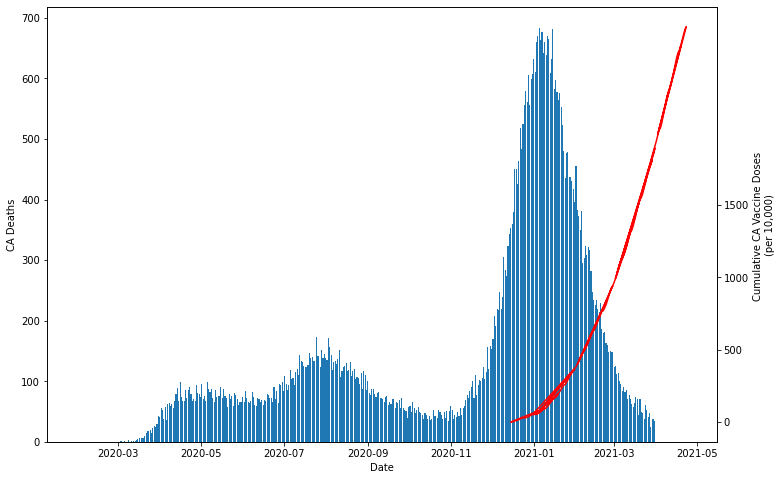

In [13]:
#covid deaths vs. vaccinations 
#
death_by_date = clean_case.groupby(['date'],as_index=False).agg({'deaths':['sum']})
death_by_date.columns = death_by_date.columns.droplevel(1)

#covid case & dates for bar graph
x1=(death_by_date['date'])
y1=(death_by_date['deaths'])

#vaccine counts and dates for line graph
x2=ca_vaccinations['administered_date']
y2=ca_vaccinations['cumulative_doses_by_10000']

#format figure
fig, axis1 = plt.subplots(figsize=(12,8))
axis2=axis1.twinx()    #create a second axis sharing the x-axis

#create bar graph using CA case counts
axis1.bar(x1,y1,)
axis1.set_ylabel("CA Deaths")
axis1.set_xlabel('Date')

#plot cumulative vaccine counts on 2nd y-axis
axis2.plot(x2,y2,color='red')
axis2.set_ylabel('Cumulative CA Vaccine Doses \n(per 10,000)')

#change y-ticks for 2nd axis
axis2.set_yticks(np.arange(0,2000,500))

plt.show()

### 2.	Do “College” towns play a larger role in case surges?

#### Part 1: Grouping Data

In [14]:
grouped_colleges = college_data.groupby('county')['Total_Enrollment'].sum().astype(int)
college_population = grouped_colleges.to_frame()
len(college_population)

41

41 of California's counties contain at least one college with student enrollment for the 2019-2020 school year.

In [15]:
cases = clean_case.rename(columns={'area': 'county'})

cases_grouped = cases.groupby('county').agg({'cases': 'sum',
                                                  'deaths': 'sum',
                                                  'total_tests': 'sum',
                                                  'positive_tests': 'sum',
                                                  'population': 'max'})

cases_grouped['Cases per 100,000'] = (cases_grouped['cases']/cases_grouped['population']*100000).astype(int)
cases_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, Alameda to Yuba
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cases              58 non-null     float64
 1   deaths             58 non-null     float64
 2   total_tests        58 non-null     float64
 3   positive_tests     58 non-null     float64
 4   population         58 non-null     float64
 5   Cases per 100,000  58 non-null     int32  
dtypes: float64(5), int32(1)
memory usage: 2.9+ KB


In [16]:
vaccine_grouped = vaccine_df.groupby('county').agg({'total_doses': 'sum',
                                                  'cumulative_fully_vaccinated': 'max'})

vaccine_grouped['Fully Vaccinated per 100,000'] = (vaccine_grouped['cumulative_fully_vaccinated']/
                                                         cases_grouped['population']*100000).astype(int)

vaccine_grouped.info()


<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, Alameda to Yuba
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   total_doses                   58 non-null     int64
 1   cumulative_fully_vaccinated   58 non-null     int64
 2   Fully Vaccinated per 100,000  58 non-null     int32
dtypes: int32(1), int64(2)
memory usage: 1.6+ KB


Both cases_grouped and vaccines_grouped dataframes contain all 58 counties.

#### Part 2: Prep and Run geocoding API

In [17]:
# Create a list of Counties included in data sets to use for geocoding API

counties = cases['county'].unique()

# Creating Lists to fill coordinates
lat = []
lng = []

# Set up for API call
base_url = 'https://maps.googleapis.com/maps/api/geocode/json?address='
    
for county in counties:
    target_county = f'{base_url}{county},+CA&key={gkey}'
    response = requests.get(target_county).json()
    try:
        lat.append(response['results'][0]['geometry']['location']['lat'])
        lng.append(response['results'][0]['geometry']['location']['lng'])
    except:
        print(f'{county} could not be located...Skipping')
        pass
print('Coordinates have been added to datasets.')

Coordinates have been added to datasets.


In [18]:
# Build county DF for heatmaps

county_dict = {'county': counties,
              'latitude': lat,
              'longitude': lng}
county_data = pd.DataFrame(county_dict)

county_data.set_index('county', inplace=True)
county_data['population'] = cases_grouped['population']
county_data['student_pop'] = college_population['Total_Enrollment']
county_data['cases per 100,000'] = cases_grouped['Cases per 100,000']
county_data['Fully Vaccinated per 100,000'] = vaccine_grouped['Fully Vaccinated per 100,000']
county_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, Alameda to Yuba
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   latitude                      58 non-null     float64
 1   longitude                     58 non-null     float64
 2   population                    58 non-null     float64
 3   student_pop                   41 non-null     float64
 4   cases per 100,000             58 non-null     int32  
 5   Fully Vaccinated per 100,000  58 non-null     int32  
dtypes: float64(4), int32(2)
memory usage: 2.7+ KB


In [19]:
county_data['student_pop'] = county_data['student_pop'].fillna(0)
county_data.reset_index(inplace=True)
county_data['% student population'] = round(county_data['student_pop']/county_data['population']*100,2)
county_data.head()

,county,latitude,longitude,population,student_pop,"cases per 100,000","Fully Vaccinated per 100,000",% student population
0,Alameda,37.779872,-122.282185,1685886.0,130485.0,4995,33949,7.74
1,Alpine,32.835052,-116.766411,1117.0,0.0,7699,53088,0.00
2,Amador,38.348892,-120.774093,38531.0,0.0,9311,25405,0.00
3,Butte,39.625395,-121.537000,217769.0,27274.0,5241,27251,12.52
4,Calaveras,38.196048,-120.680504,44289.0,0.0,4545,25898,0.00


In [20]:
#Calculating 3rd quartile for heatmap max intensities

county_data.quantile(0.75)

latitude                            39.259846
longitude                         -119.902711
population                      724076.500000
student_pop                      40256.000000
cases per 100,000                 9283.500000
Fully Vaccinated per 100,000     30233.750000
% student population                 7.425000
Name: 0.75, dtype: float64

In [21]:
# Locating all counties in the top quartile as "College Counties"

college_counties = county_data.loc[county_data['% student population']>=7.425]
len(college_counties)

15

In [22]:
# Creating heat map of Covid-19 cases

center = 36.7783,-119.4179
counties = county_data[['latitude', 'longitude']]
cases = cases_grouped['Cases per 100,000']

fig1 = gmaps.figure(center=center, zoom_level=5.5)

heatmap_layer_cases = gmaps.heatmap_layer(counties, weights=cases, dissipating=False)
heatmap_layer_cases.max_intensity = 9283
heatmap_layer_cases.point_radius = 0.25

fig1.add_layer(heatmap_layer_cases)

#add college counties to the 2020 heatmap

info_box_template = """
<dl>
<dt>County</dt><dd>{county}</dd>
<dt>% Students</dt><dd>{% student population}</dd>
<dt>Cases per 100,000</dt><dd>{cases per 100,000}</dd>
</dl>
"""
# Store the DataFrame Row

county_info = [info_box_template.format(**row) for index, row in college_counties.iterrows()]
locations = college_counties[['latitude', 'longitude']]

# Add marker layer ontop of heat map

markers = gmaps.marker_layer(locations, info_box_content=county_info)
fig1.add_layer(markers)

# Display figure

fig1

Figure(layout=FigureLayout(height='420px'))

The above heatmap was originally broken down by year to see the affect of lower student populations due to virtual learning. However, the maps were identical. This also suggests that each county is maintaining it's own Covid-19 curve. No county appears to have dramatically changed its numbers between 2020 and 2021.

In [23]:
# Creating heat map of Vaccines

center = 36.7783,-119.4179
counties = county_data[['latitude', 'longitude']]
cases = county_data['Fully Vaccinated per 100,000']

fig3 = gmaps.figure(center=center, zoom_level=5.5)

heatmap_layer_vaccines = gmaps.heatmap_layer(counties, weights=cases, dissipating=False)
heatmap_layer_vaccines.max_intensity = 30233
heatmap_layer_vaccines.point_radius = 0.25
heatmap_layer_vaccines.gradient = [(255,0,0, 0),
                                   (255,0,0, 1),
                                   (255,255,0, 1),
                                   (0,255,0, 1)]

fig3.add_layer(heatmap_layer_vaccines)

#add college counties to the Vaccine heatmap

info_box_template = """
<dl>
<dt>County</dt><dd>{county}</dd>
<dt>% Students</dt><dd>{% student population}</dd>
<dt>Cases per 100,000</dt><dd>{Fully Vaccinated per 100,000}</dd>
</dl>
"""
# Store the DataFrame Row

county_info = [info_box_template.format(**row) for index, row in college_counties.iterrows()]
locations = college_counties[['latitude', 'longitude']]

# Add marker layer ontop of heat map

markers = gmaps.marker_layer(locations, info_box_content=county_info)
fig3.add_layer(markers)

# Display figure

fig3

Figure(layout=FigureLayout(height='420px'))

Inverted colors on Vaccines heat map as a greater number of vaccines per 100,000 people is considered good.

### 3.	Are there “Vaccination Deserts”? What impact have Covid-19 and the vaccines had in these areas?

### 4.	Can we predict when California will return to “normal”?